In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
data_dir='./Belgium Datasets'
train_dir=data_dir+'/BelgiumTSC_Training/Training'
test_dir=data_dir+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [3]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0


In [4]:
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0
5,./Belgium Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0.0,0


In [6]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0


In [24]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 35
resize_y  = 35
num_of_channels = 3
directory = ""
Epochs=25
train_length = len(df)

In [25]:
# Necessary Functions

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
def upSampleDataFrame(df,upSampleCount=300):
    starting_time = time.time()
    classes = {}

    for val in range(num_of_classes):
        classes[val]=[]

    max_repeating = 0

    for index,row in df.iterrows():
        classes[row.values[7]].append(row.values)

    # for key in classes:
    #     max_repeating = max(max_repeating,len(classes[key]))
    
    row = []
    random.seed(42)
    for i in range(num_of_classes):
        length = len(classes[i])
        want = upSampleCount - length
        for j in range(len(classes[i])):
            row.append(classes[i][j])
        if(want<=0):
            continue
        for j in range(want):
            select_image = random.randint(0,length-1)
            angle = random.randint(0,359)
            f = classes[i].copy()
            f[0][8] = angle
            row.append(f[0])
    np.random.seed(42)
    np.random.shuffle(row)

    df = pd.DataFrame(row,columns = df.columns)

    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Total number of images after Upsampling: ", len(df))
    print("\n\nTime taken to upsample images : ",total_time," min")
    return df

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[0]).crop((row[3],row[4],row[5],row[6])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[7])

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[0]).crop((row[3],row[4],row[5],row[6])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[7])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  31000


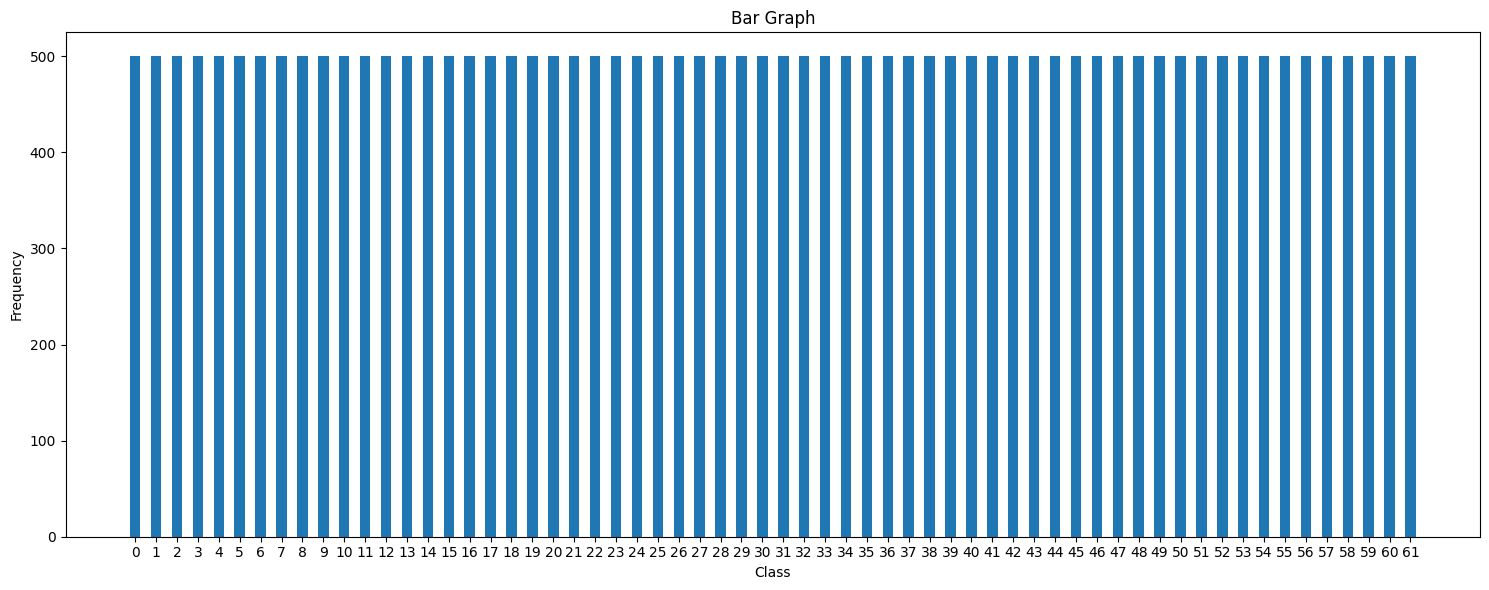

In [26]:
#Statistics of Data
viewStatistics(df)

In [27]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  31000


Total number of images after Upsampling:  31000


Time taken to upsample images :  0.4992708325386047  min
Total Training Examples :  31000


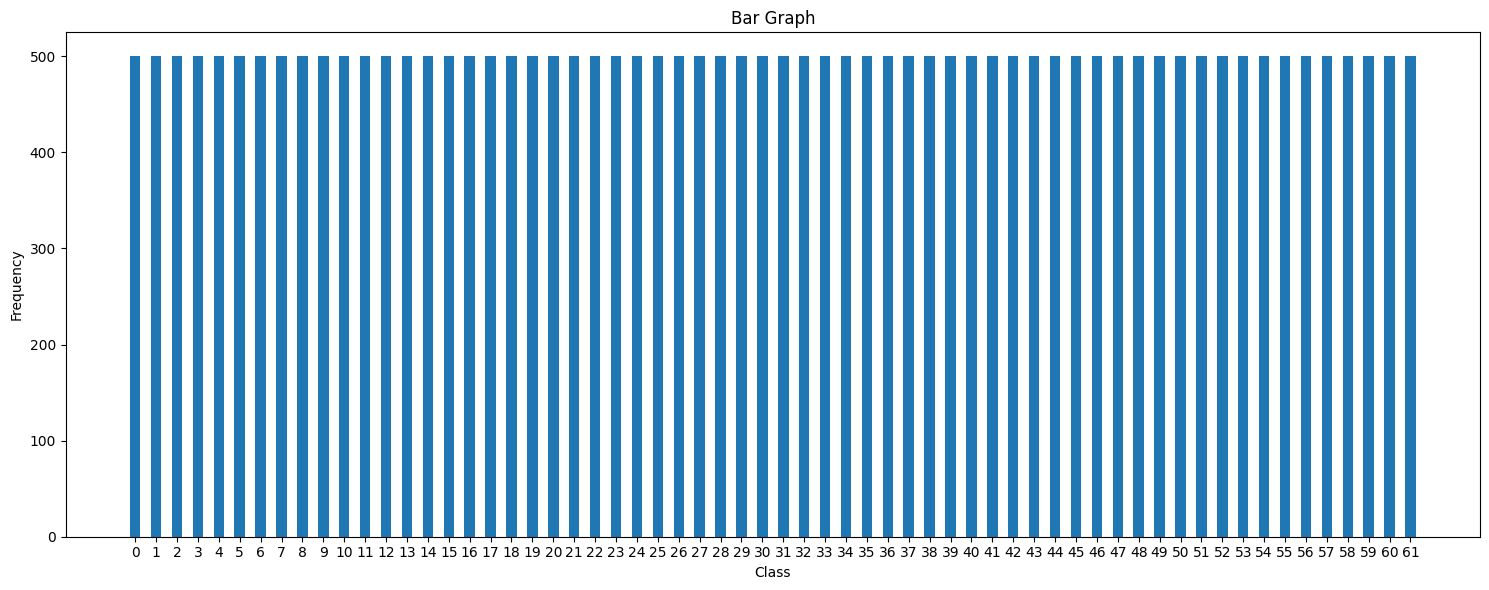

In [28]:
df = upSampleDataFrame(df,500)
viewStatistics(df)

In [29]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        img = img.rotate(val[8])
        ax = axes[row,col+1]
        ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [30]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def Do_Crop(self,path,x1,y1,x2,y2,r):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.rotate(r)
        img = img.resize((self.resize_x,self.resize_y))
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row.iloc[0],row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[6],row.iloc[8]))
        self.Y.append(int(row.iloc[7]))
    
    def Get_Data(self,length):
        self.X = []
        self.Y = []
        want = [0]*num_of_classes
        for i in range(len(df)):
            row = df.iloc[i]
            if(want[int(row.iloc[6])]<length):
                want[int(row.iloc[6])] = want[int(row.iloc[6])]+1
                self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(df)):
            row = df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

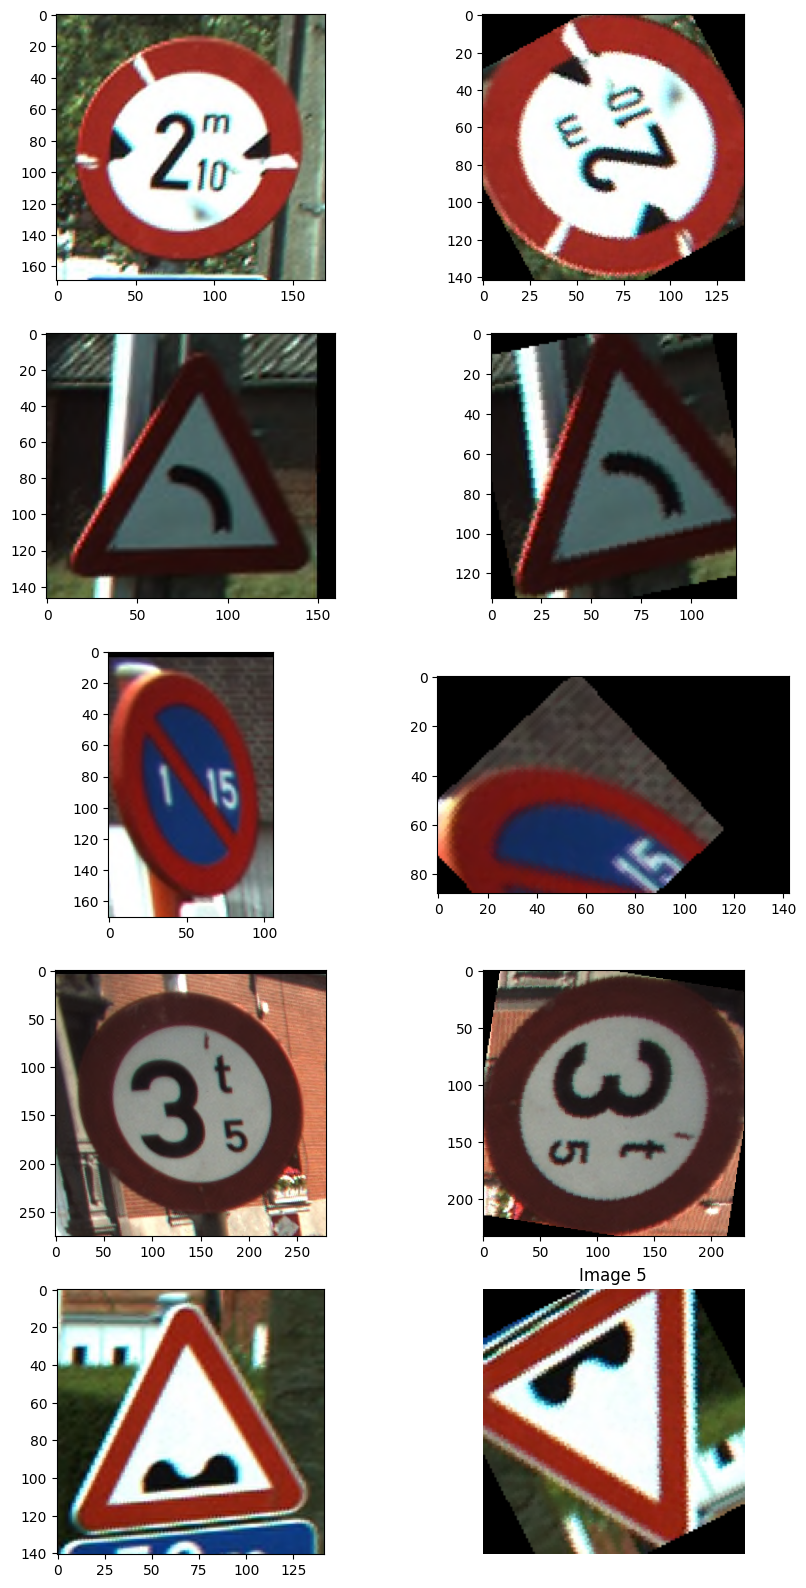

In [31]:
showExamples(df)

In [32]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  6.211796534061432  min


In [33]:
X_train = data.X
Y_train = data.Y

In [34]:
#Data_Augmentation
X_train = X_train/255.0

In [35]:
# conversion of Y_train into 2d array in order to feed CNN 
Temp = []
for i in range(len(Y_train)):
    row = [0]*len(trainClasses)
    row[Y_train[i]]=1
    Temp.append(np.array(row))
Y_train = np.array(Temp)

In [41]:
# Implementation of ANN
model = Sequential()
model.add(Flatten(input_shape=(resize_x, resize_y, num_of_channels)))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(trainclasses), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3675)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                235264    
                                                                 
 dense_4 (Dense)             (None, 62)                4030      
                                                                 
Total params: 239294 (934.74 KB)
Trainable params: 239294 (934.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.3)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/25
679/679 [==============================] - 17s 21ms/step - loss: 0.7382 - accuracy: 0.8641 - val_loss: 0.3535 - val_accuracy: 0.9243
Epoch 2/25
679/679 [==============================] - 10s 15ms/step - loss: 0.2747 - accuracy: 0.9392 - val_loss: 0.3114 - val_accuracy: 0.9292
Epoch 3/25
679/679 [==============================] - 10s 15ms/step - loss: 0.2130 - accuracy: 0.9488 - val_loss: 0.2488 - val_accuracy: 0.9411
Epoch 4/25
679/679 [==============================] - 11s 16ms/step - loss: 0.1687 - accuracy: 0.9577 - val_loss: 0.2267 - val_accuracy: 0.9500
Epoch 5/25
679/679 [==============================] - 11s 16ms/step - loss: 0.1508 - accuracy: 0.9609 - val_loss: 0.1754 - val_accuracy: 0.9612
Epoch 6/25
679/679 [==============================] - 10s 15ms/step - loss: 0.1292 - accuracy: 0.9660 - val_loss: 0.1807 - val_accuracy: 0.9558
Epoch 7/25
679/679 [==============================] - 10s 15ms/step - loss: 0.1066 - accuracy: 0.9720 - val_loss: 0.1791 - val_accuracy:

In [44]:
#Saving the model
model.save("ANN_Model-SingleLayered_Belgium")

INFO:tensorflow:Assets written to: ANN_Model-SingleLayered_Belgium\assets


INFO:tensorflow:Assets written to: ANN_Model-SingleLayered_Belgium\assets


In [45]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

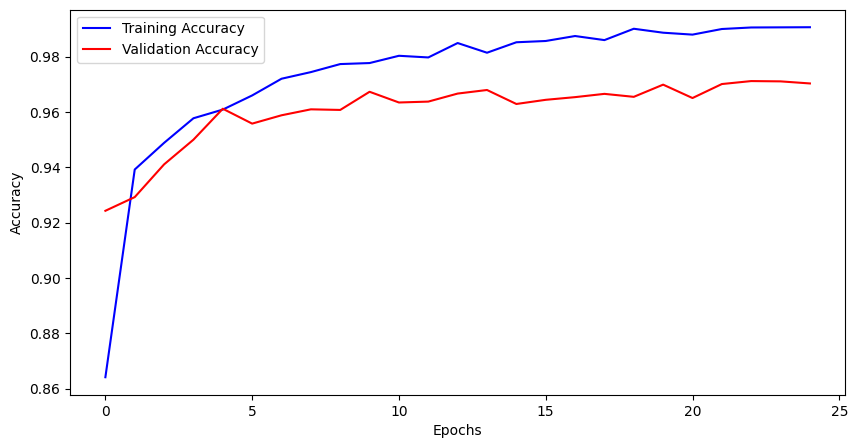

In [46]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

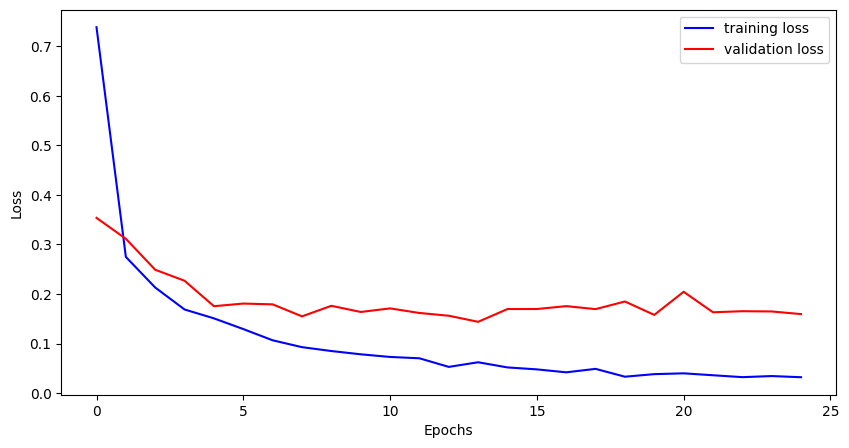

In [47]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [49]:
#Loading weights into CNN model 
model = tf.keras.models.load_model("ANN_Model-SingleLayered_Belgium")

In [50]:
df_test=[[]]
df_test=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
0,./Belgium Datasets/BelgiumTSC_Training/Trainin...,181.0,141.0,15.0,12.0,165.0,128.0,50.0,0
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,248.0,266.0,21.0,22.0,227.0,244.0,25.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,59.0,62.0,5.0,5.0,53.0,57.0,2.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,199.0,206.0,17.0,17.0,181.0,189.0,15.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,240.0,111.0,20.0,9.0,219.0,101.0,48.0,0


In [51]:
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
0,./Belgium Datasets/BelgiumTSC_Training/Trainin...,181.0,141.0,15.0,12.0,165.0,128.0,50.0,0
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,248.0,266.0,21.0,22.0,227.0,244.0,25.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,59.0,62.0,5.0,5.0,53.0,57.0,2.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,199.0,206.0,17.0,17.0,181.0,189.0,15.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,240.0,111.0,20.0,9.0,219.0,101.0,48.0,0


Total Training Examples :  31000


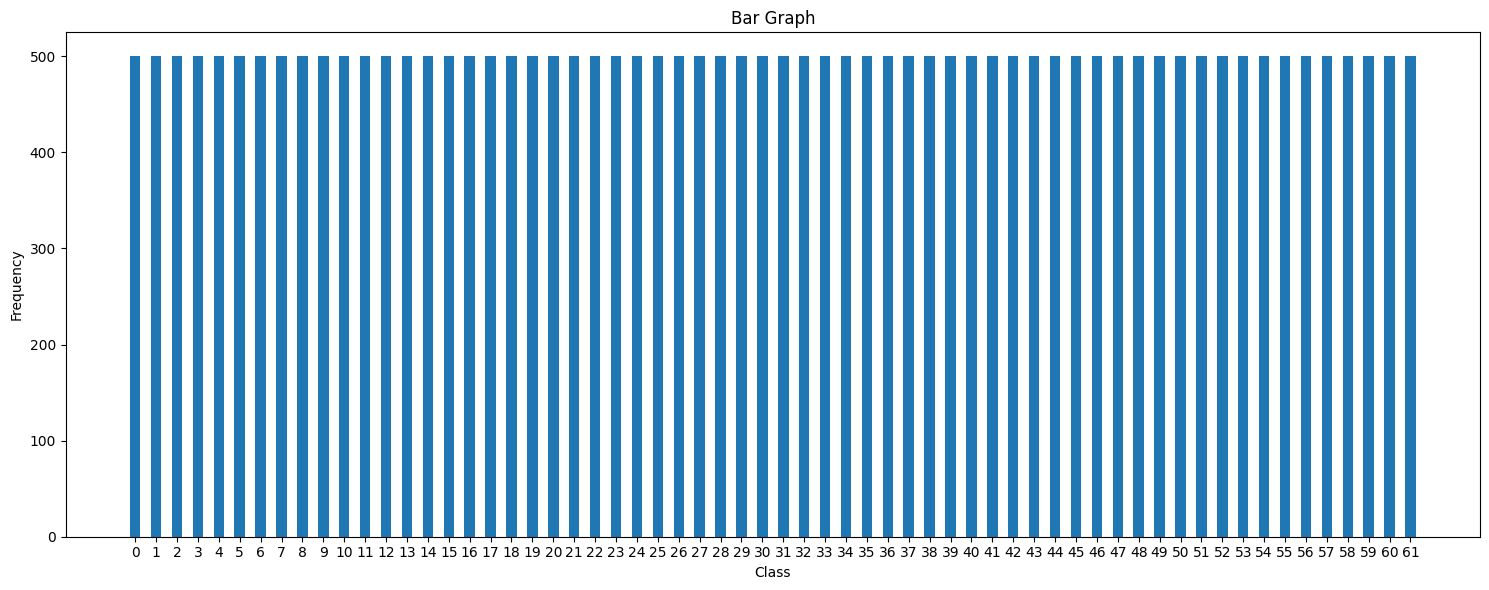

In [52]:
viewStatistics(df_test)

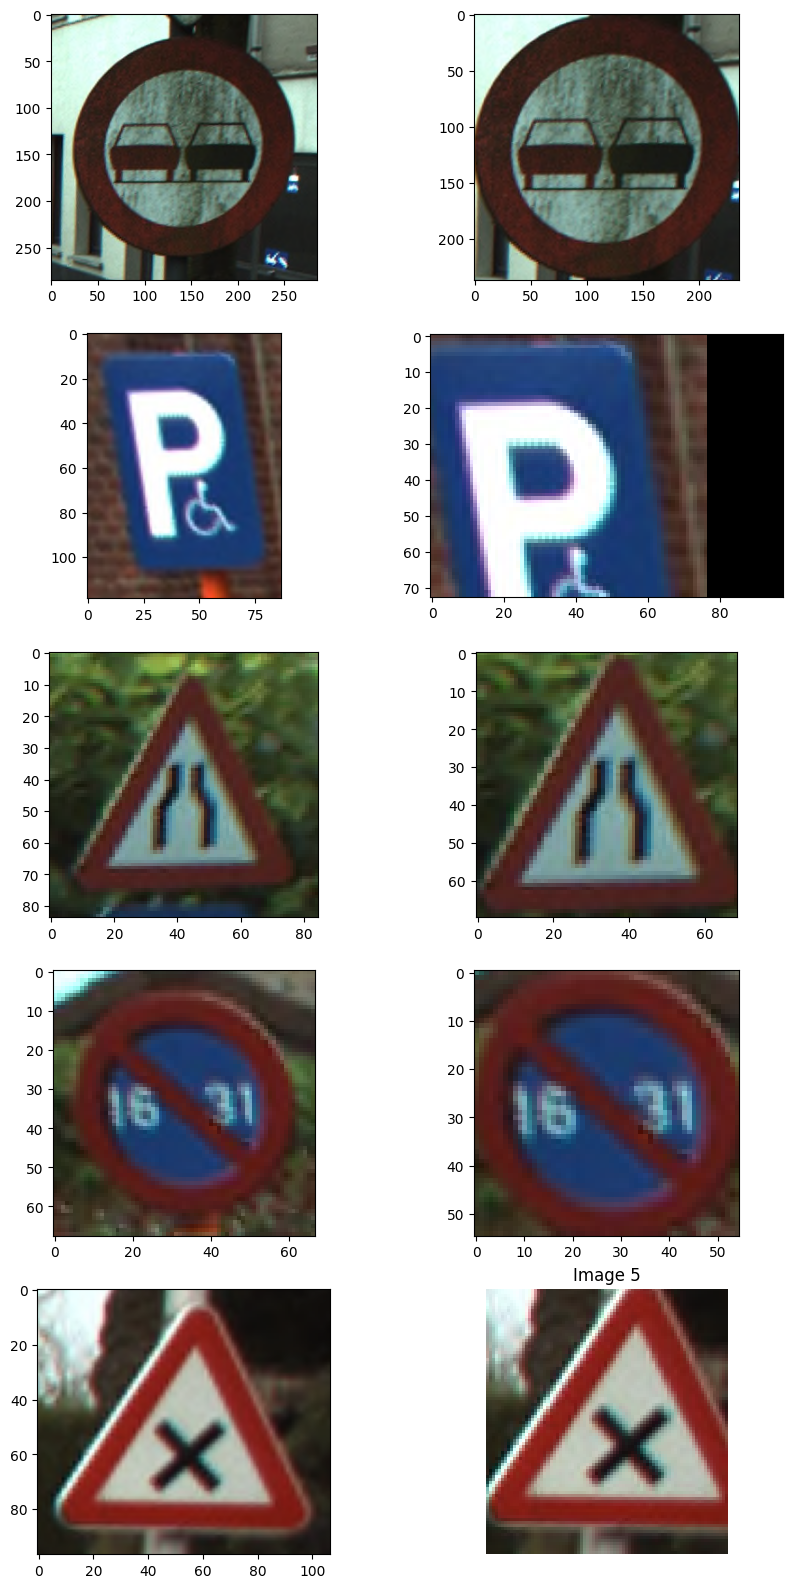

In [53]:
showExamples(df_test)

In [54]:
df_test = upSampleDataFrame(df_test,750)

Total number of images after Upsampling:  46500


Time taken to upsample images :  0.08484957615534465  min


In [55]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000
mean,148.386452,136.978215,12.446839,11.517892,135.448516,124.956774,30.500000,63.775591
std,71.812831,75.509614,5.928718,6.244594,65.891424,69.319187,17.895723,104.973373
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.000000
25%,94.000000,74.000000,8.000000,6.000000,86.000000,67.000000,15.000000,0.000000
50%,136.000000,118.000000,11.000000,10.000000,125.000000,108.000000,30.500000,0.000000
75%,193.000000,171.000000,16.000000,14.000000,177.000000,156.000000,46.000000,118.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,351.000000


In [56]:
# Test Images Prediction
y_test,y_pred = PredictTest(model,df_test)

1454/1454 [==============================] - 7s 5ms/step


In [57]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  54.60215053763441

Confusion Matrix:
 [[498   1   0 ...   0   0   0]
 [  0 746   0 ...   0   0   0]
 [  0   0 499 ...   0   0   0]
 ...
 [  0   0   0 ... 499   0   0]
 [  0   0   0 ...   0   6 492]
 [  0   1   0 ...   0   0 494]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,1.00,0.66,0.80,750
1,1,0.63,0.99,0.77,750
2,2,0.34,0.67,0.45,750
3,3,0.66,0.66,0.66,750
4,4,1.00,0.66,0.80,750
...,...,...,...,...,...
57,57,0.24,0.11,0.15,750
58,58,0.92,0.02,0.03,750
59,59,0.66,0.67,0.66,750
60,60,1.00,0.01,0.02,750


Original Value :  97.0
1/1 [==============================] - 0s 51ms/step
Predicted Value :  41


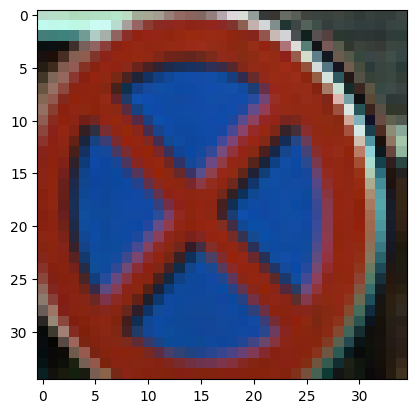

In [58]:
# Testing one Random Image from test data 
test_length = len(df_test)
select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row.iloc[0])
img = img.crop((row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[6]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)

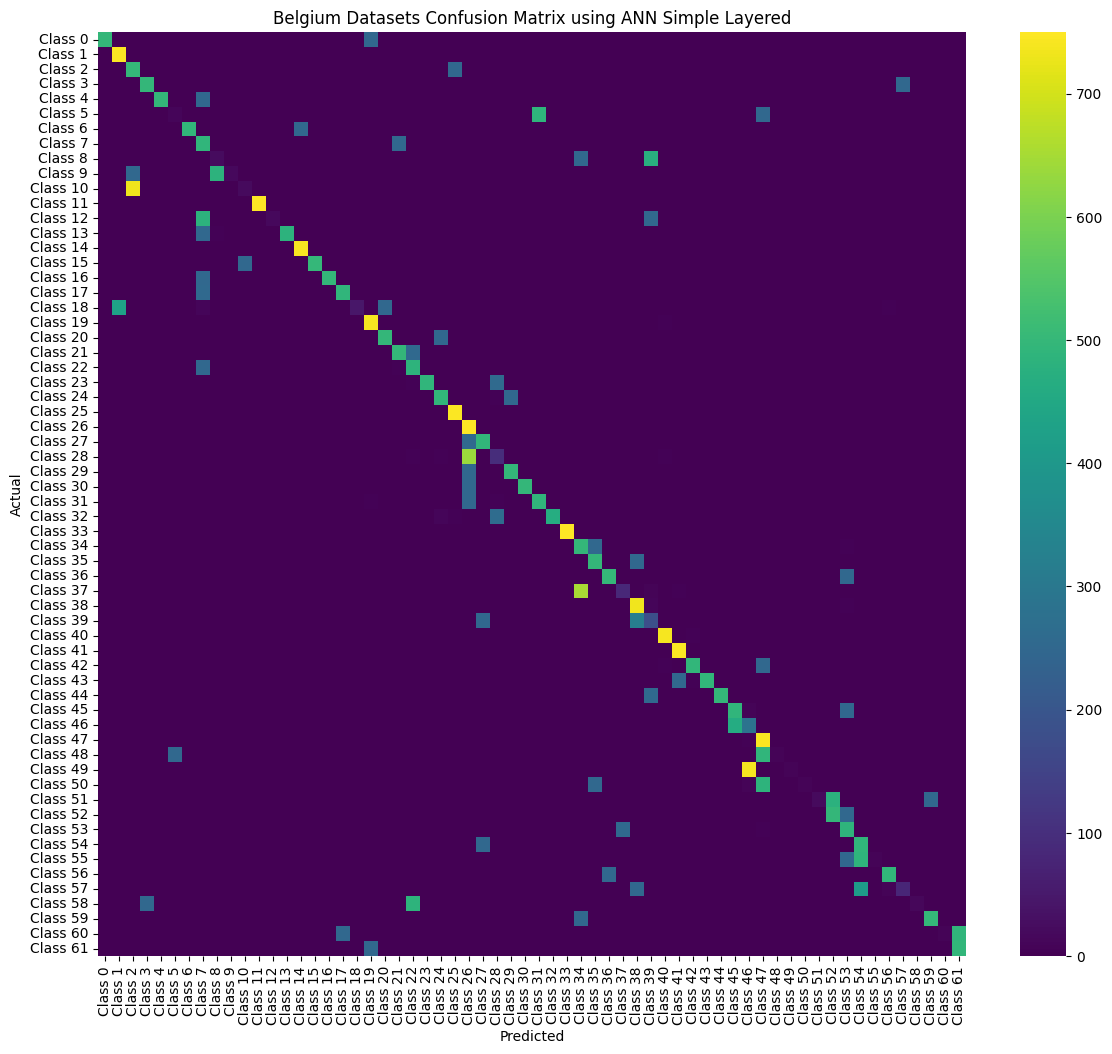

In [64]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Belgium Datasets Confusion Matrix using ANN Simple Layered')
plt.show()